# Analyzing a Specific Company's SEC Filings using FinFeedAPI

## Introduction

This notebook demonstrates how to use the FinFeedAPI to focus on the SEC filings of a single company, identified by its Central Index Key (CIK). This allows for targeted analysis of a company's reporting history, key events, and specific disclosures.

We will cover:
1.  **Fetching Filings for a Specific CIK:** Using the `/v1/filings` endpoint with the `cik` parameter.
2.  **Visualizing Filing Timeline:** Plotting the dates of different types of filings (10-K, 10-Q, 8-K) over time.
3.  **Analyzing Form Type Frequency:** Counting the occurrences of different forms filed by the company.
4.  **Extracting Specific Content:** Using `/v1/extractor/item` to retrieve key sections like "Risk Factors" (Item 1A) from the latest 10-K or specific items from recent 8-Ks.

## Environment Setup

In [1]:
pip install api-bricks-sec-api-rest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from datetime import datetime
import os
from IPython.display import display
import api_bricks_sec_api_rest

# --- API Configuration ---
API_KEY = "YOUR_API_KEY_HERE"  # <--- REPLACE THIS WITH YOUR ACTUAL KEY!
api_client = api_bricks_sec_api_rest.ApiClient(header_name="Authorization", header_value=API_KEY)

# --- Target Company ---
# Replace with the CIK of the company you want to analyze
# Example CIKs: Apple (320193), Microsoft (789019), Google (1652044)
TARGET_CIK = 320193 # Example: Apple Inc.

# --- Plotting Configuration ---
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    print("Seaborn style 'seaborn-v0_8-darkgrid' not found, using default.")
    plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 7) # Adjust figure size

## 1. Fetching Filings for the Target CIK

We use the `/v1/filings` endpoint, specifying the `cik` and desired `form_type` (e.g., 10-K, 10-Q, 8-K). We'll fetch filings over a specific period (e.g., the last 5 years) and handle pagination if necessary.



In [8]:
# Define time range and other parameters
end_date = datetime.now().strftime('%Y-%m-%d')
start_date_dt = datetime.now() - pd.DateOffset(years=5)
start_date = start_date_dt.strftime('%Y-%m-%d')

print(f"Fetching filings for CIK {TARGET_CIK} from {start_date} to {end_date}...")

company_filings = []
current_page = 1
page_size = 200 # Max page size

api_instance = api_bricks_sec_api_rest.FilingMetadataApi(api_client)

while True:
    page_data = api_instance.v1_filings_get (
        cik = TARGET_CIK,
        filling_date_start = start_date,
        filling_date_end = end_date,
        page_size = page_size,
        page_number= current_page
    )

    if page_data is not None and isinstance(page_data, list) and len(page_data) > 0:
        company_filings.extend(page_data)
        print(f"  Fetched page {current_page}, {len(page_data)} records. Total: {len(company_filings)}")
        if len(page_data) < page_size:
            print(f"  Last page reached.")
            break
        current_page += 1
    else:
        if page_data == []: print(f"  No more data found on page {current_page}.")
        else: print(f"  API error or unexpected response on page {current_page}. Stopping fetch.")
        break

# Process the results
if company_filings:
    company_filings_df = pd.DataFrame.from_records([vars(x) for x in company_filings])
    date_columns = ['filing_date', 'report_date', 'acceptance_date_time']
    for col in date_columns:
        if col in company_filings_df.columns:
            company_filings_df[col] = pd.to_datetime(company_filings_df[col], errors='coerce')

    print(f"\nSuccessfully fetched {len(company_filings_df)} total filings for CIK {TARGET_CIK}.")
    print("\nSample of fetched data:")
    display(company_filings_df[['filing_date', 'form', 'accession_number', 'primary_doc_description']].head())
else:
    print(f"\nNo filings found for CIK {TARGET_CIK} in the specified date range.")
    company_filings_df = pd.DataFrame() # Create empty DataFrame

Fetching filings for CIK 320193 from 2020-05-16 to 2025-05-16...
  Fetched page 1, 200 records. Total: 200
  Fetched page 2, 190 records. Total: 390
  Last page reached.

Successfully fetched 390 total filings for CIK 320193.

Sample of fetched data:


,filing_date,form,accession_number,primary_doc_description
0,2022-03-04,8-K,0001193125-22-066169,8-K
1,2022-03-08,4,0000320193-22-000034,FORM 4
2,2022-03-08,4,0000320193-22-000035,FORM 4
3,2022-03-08,4,0000320193-22-000036,FORM 4
4,2022-03-08,4,0000320193-22-000037,FORM 4


## 2. Visualizing Filing Timeline

Let's plot the occurrences of major filing types (10-K, 10-Q, 8-K) on a timeline.

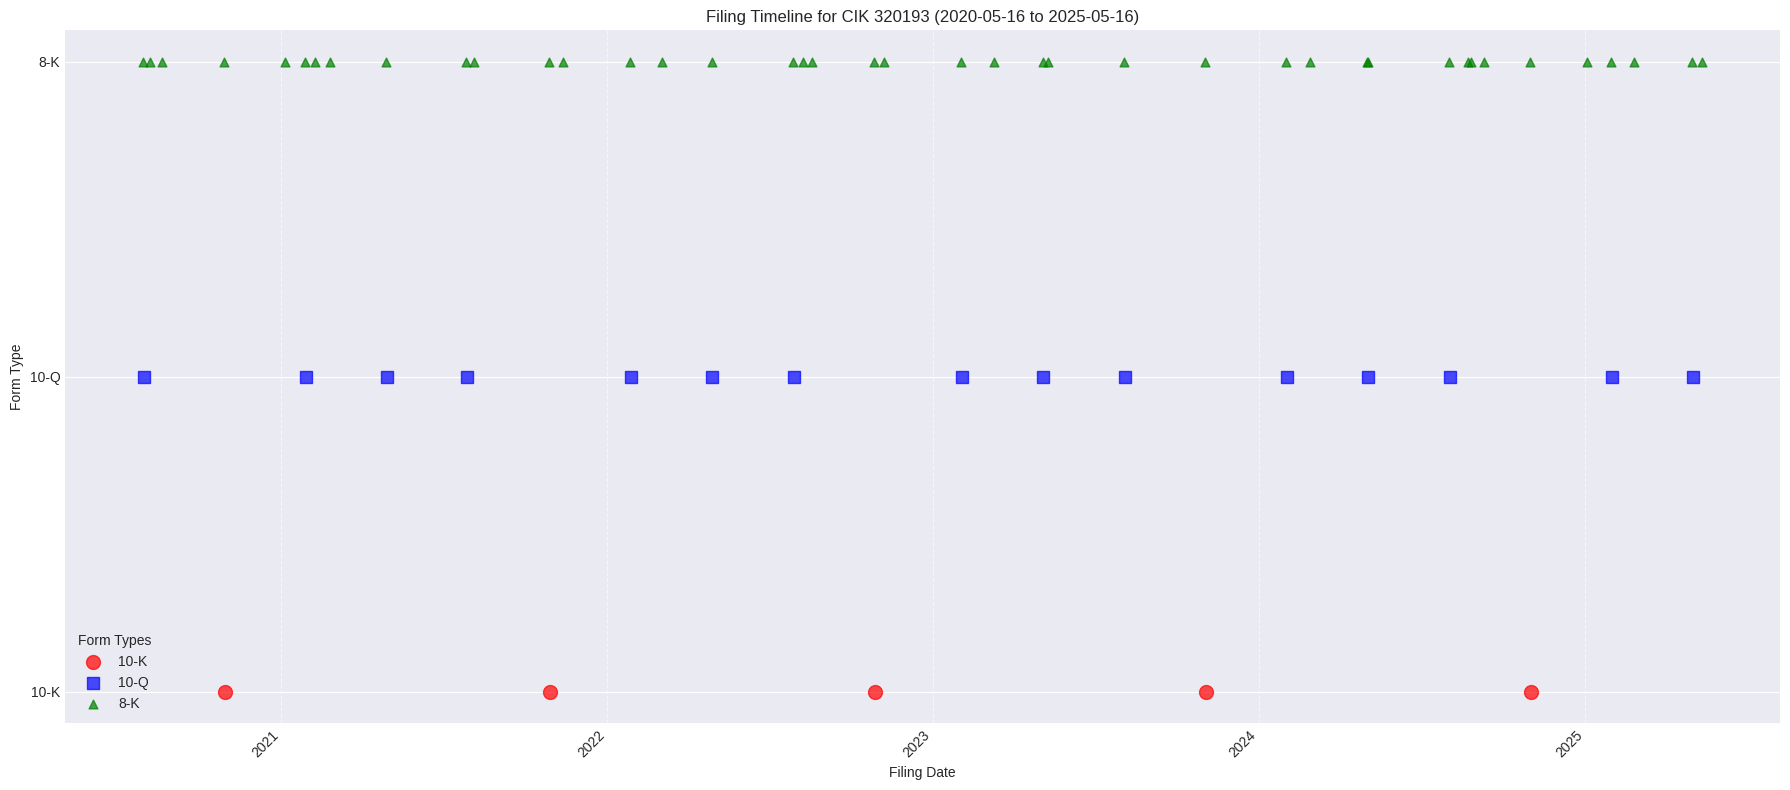

In [5]:
if not company_filings_df.empty:
    # Filter for major form types
    major_forms = ['10-K', '10-Q', '8-K']
    timeline_df = company_filings_df[company_filings_df['form'].isin(major_forms)].copy()
    timeline_df = timeline_df.dropna(subset=['filing_date']) # Ensure valid dates

    if not timeline_df.empty:
        # Create the plot
        fig, ax = plt.subplots(figsize=(18, 8))

        colors = {'10-K': 'red', '10-Q': 'blue', '8-K': 'green'}
        markers = {'10-K': 'o', '10-Q': 's', '8-K': '^'}
        sizes = {'10-K': 100, '10-Q': 70, '8-K': 40}

        for form_type in major_forms:
            subset = timeline_df[timeline_df['form'] == form_type]
            if not subset.empty:
                ax.scatter(subset['filing_date'], subset['form'],
                           label=form_type,
                           color=colors[form_type],
                           marker=markers[form_type],
                           s=sizes[form_type], # Size of the marker
                           alpha=0.7)

        # Formatting the plot
        ax.set_title(f'Filing Timeline for CIK {TARGET_CIK} ({start_date} to {end_date})')
        ax.set_xlabel('Filing Date')
        ax.set_ylabel('Form Type')
        ax.legend(title="Form Types")
        ax.grid(True, axis='x', linestyle='--', alpha=0.6)

        # Improve date formatting on x-axis
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
    else:
        print("No 10-K, 10-Q, or 8-K filings found in the fetched data for timeline visualization.")

else:
    print("DataFrame is empty. Skipping timeline visualization.")

## 3. Analyzing Form Type Frequency

Count how many times each form type was filed in the fetched period.


Frequency of Form Types for CIK 320193 (2020-05-16 to 2025-05-16):
form
4             210
8-K            41
144            31
PX14A6G        21
10-Q           15
424B2          12
SC 13G/A       11
FWP             6
DEFA14A         6
DEF 14A         5
10-K            5
SD              5
3               4
CORRESP         3
UPLOAD          3
25-NSE          2
S-8 POS         2
IRANNOTICE      2
S-3ASR          2
4/A             1
5               1
S-8             1
PX14A6N         1
Name: count, dtype: int64


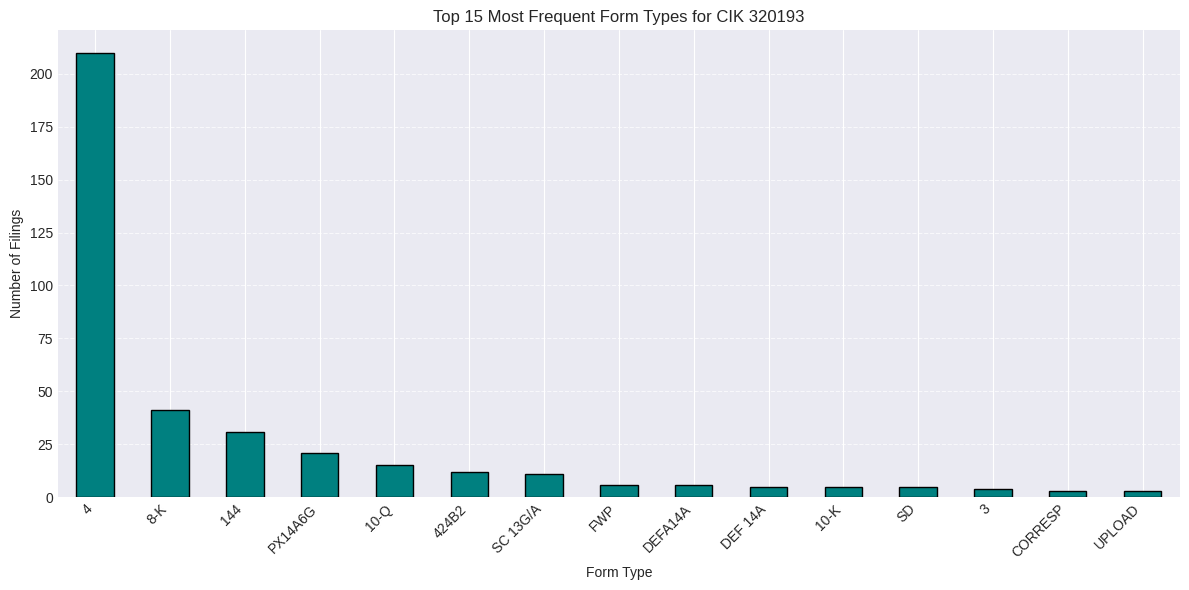

In [6]:
if not company_filings_df.empty:
    form_counts = company_filings_df['form'].value_counts()

    print(f"\nFrequency of Form Types for CIK {TARGET_CIK} ({start_date} to {end_date}):")
    print(form_counts)

    # Plot the top N form types
    top_n = 15
    plt.figure(figsize=(12, 6))
    form_counts.head(top_n).plot(kind='bar', color='teal', edgecolor='black')
    plt.title(f'Top {top_n} Most Frequent Form Types for CIK {TARGET_CIK}')
    plt.xlabel('Form Type')
    plt.ylabel('Number of Filings')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty. Skipping form type frequency analysis.")

## 4. Extracting Specific Content

Let's extract "Risk Factors" (Item 1A) from the most recent 10-K and potentially details from the most recent 8-K.

### 4.1 Extracting Risk Factors (Item 1A from latest 10-K)


In [10]:
if not company_filings_df.empty:
    # Find the most recent 10-K filing
    latest_10k = company_filings_df[company_filings_df['form'] == '10-K'].sort_values('filing_date', ascending=False).iloc[1]

    if not latest_10k.empty:
        latest_10k_acc_no = latest_10k['accession_number']
        print(f"\nAttempting to extract 'Item 1A' (Risk Factors) from latest 10-K: {latest_10k_acc_no}")

        api_instance2 = api_bricks_sec_api_rest.ContentExtractionApi(api_client)
        risk_factors_content = api_instance2.v1_extractor_item_get (
            accession_number = latest_10k_acc_no,
            item_number = "1A" # Standard item number for Risk Factors in 10-K
            # Note: Sometimes it might be 'Item 1A'. The API should handle variations if possible.
            # Check API docs or examples if '1A' doesn't work.
        )

        if risk_factors_content is not None:
            print(f"\nSuccessfully extracted Risk Factors (Item 1A). Preview (first 1000 chars):")
            print(risk_factors_content[:1000] + ('...' if len(risk_factors_content) > 1000 else ''))
        else:
            # Try alternative common naming if the first attempt failed
            print(f"Could not extract 'Item 1A' using '1A'. Trying 'Item 1A'...")
            item_params["item_number"] = "Item 1A"
            risk_factors_content = fetch_finfeed_data("/v1/extractor/item", params=item_params)
            if risk_factors_content is not None:
                 print(f"\nSuccessfully extracted Risk Factors using 'Item 1A'. Preview (first 1000 chars):")
                 print(risk_factors_content[:1000] + ('...' if len(risk_factors_content) > 1000 else ''))
            else:
                 print(f"Failed to extract Risk Factors (Item 1A) from {latest_10k_acc_no} using common identifiers.")

    else:
        print("\nNo 10-K filings found in the fetched data.")

else:
    print("DataFrame is empty. Skipping content extraction.")


Attempting to extract 'Item 1A' (Risk Factors) from latest 10-K: 0000320193-23-000106

Successfully extracted Risk Factors (Item 1A). Preview (first 1000 chars):
Item 1A. Risk Factors The Company’s business, reputation, results of operations, financial condition and stock price can be affected by a number of factors, whether currently known or unknown, including those described below. When any one or more of these risks materialize from time to time, the Company’s business, reputation, results of operations, financial condition and stock price can be materially and adversely affected. Because of the following factors, as well as other factors affecting the Company’s results of operations and financial condition, past financial performance should not be considered to be a reliable indicator of future performance, and investors should not use historical trends to anticipate results or trends in future periods. This discussion of risk factors contains forward-looking statements. This sec

### 4.2 Extracting Items from latest 8-K

In [15]:
if not company_filings_df.empty:
    # Find the most recent 8-K filing
    latest_8k_list = company_filings_df[company_filings_df['form'] == '8-K'].sort_values('filing_date', ascending=False)

    if not latest_8k_list.empty:
        latest_8k = latest_8k_list.iloc[0]
        latest_8k_acc_no = latest_8k['accession_number']
        print(f"\nAttempting to extract full structure from latest 8-K: {latest_8k_acc_no}")

        extracted_8k_data = api_instance2.v1_extractor_get (
            accession_number = latest_8k_acc_no
        )

        if extracted_8k_data is not None:
            print(f"\nExtracted items from 8-K {latest_8k_acc_no}:")
            for item in extracted_8k_data.items:
                print(f"  - Item Number: {item.item_number}")
                print(f"    Item Title: {item.item_title}")
                content_preview = item.content
                print(f"    Content Preview: {content_preview[:150]}...")
        else:
            print(f"Could not extract items structure from 8-K {latest_8k_acc_no}.")
    else:
        print("\nNo 8-K filings found in the fetched data.")
else:
    print("DataFrame is empty. Skipping 8-K content extraction.")


Attempting to extract full structure from latest 8-K: 0001140361-25-018400

Extracted items from 8-K 0001140361-25-018400:
  - Item Number: 801
    Item Title: Other Events
    Content Preview: Other Events. On May 12, 2025, Apple Inc. (“Apple”) consummated the issuance and sale of $1,500,000,000 aggregate principal amount of its 4.000% Notes...
  - Item Number: 901
    Item Title: Financial Statements and Exhibits
    Content Preview: Item 9.01 Financial Statements and Exhibits. (d) Exhibits. Exhibit Number Exhibit Description 1.1 Underwriting Agreement, dated May 5, 2025, among App...


## Conclusion

This notebook demonstrated how to use the FinFeedAPI to perform a focused analysis on a single company identified by its CIK. We fetched its filing history, visualized the timeline of major reports, analyzed the frequency of different form types, and extracted specific content like Risk Factors from the latest 10-K and item details from the latest 8-K.

This targeted approach can be valuable for:
* Due diligence on a specific company.
* Tracking reporting patterns and significant events.
* Extracting specific disclosures for further quantitative or qualitative analysis.